In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio, phys_grad, compute_core_mean

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,q22,Rc,psi0,A,R,Age,Date,fname,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,11.563679,343.688930
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,12.848125,334.097803
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,NaN,NaN


In [6]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

levels_lat = [-40, -35, -30, -25]
levels_lon = [150, 155, 160]


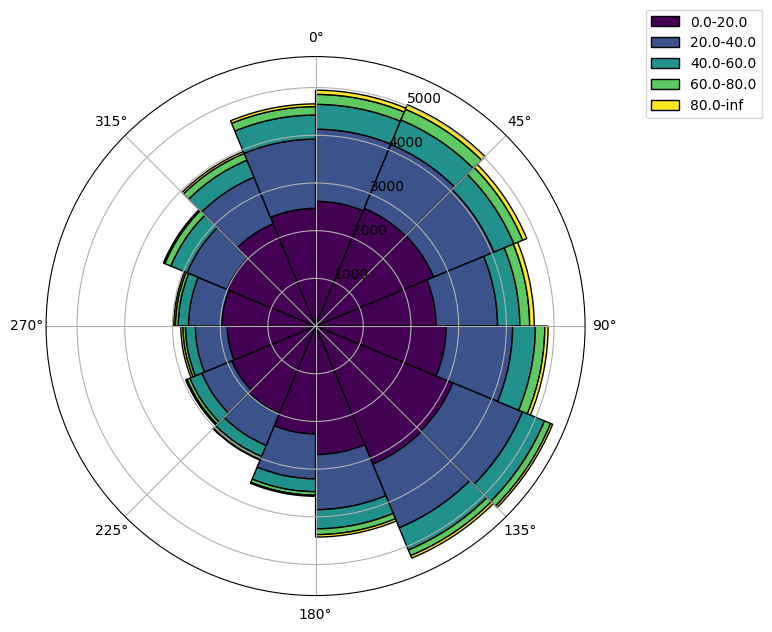

In [3]:
# Replace these with your actual data arrays
directions = df_eddies.TiltDir
magnitudes = df_eddies.TiltDis

# Define bins
dir_bins = np.linspace(0, 360, 17)  # 16 directional sectors
# mag_bins = np.linspace(magnitudes.min(), magnitudes.max(), 5)  # 4 strength categories
mag_bins = [0, 20, 40, 60, 80, np.inf]

# Digitise
dir_idx = np.digitize(directions, dir_bins) - 1
mag_idx = np.digitize(magnitudes, mag_bins) - 1

# Count occurrences per bin
counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
for d, m in zip(dir_idx, mag_idx):
    if 0 <= d < len(dir_bins)-1 and 0 <= m < len(mag_bins)-1:
        counts[m, d] += 1

# Prepare polar plot
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / n_dirs
bottom = np.zeros(n_dirs)
colors = plt.cm.viridis(np.linspace(0, 1, len(mag_bins)-1))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7,7))
for i in range(len(mag_bins)-1):
    ax.bar(angles, counts[i], width, bottom=bottom,
           color=colors[i], edgecolor='k',
           label=f'{mag_bins[i]:.1f}-{mag_bins[i+1]:.1f}')
    bottom += counts[i]

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))
plt.show()


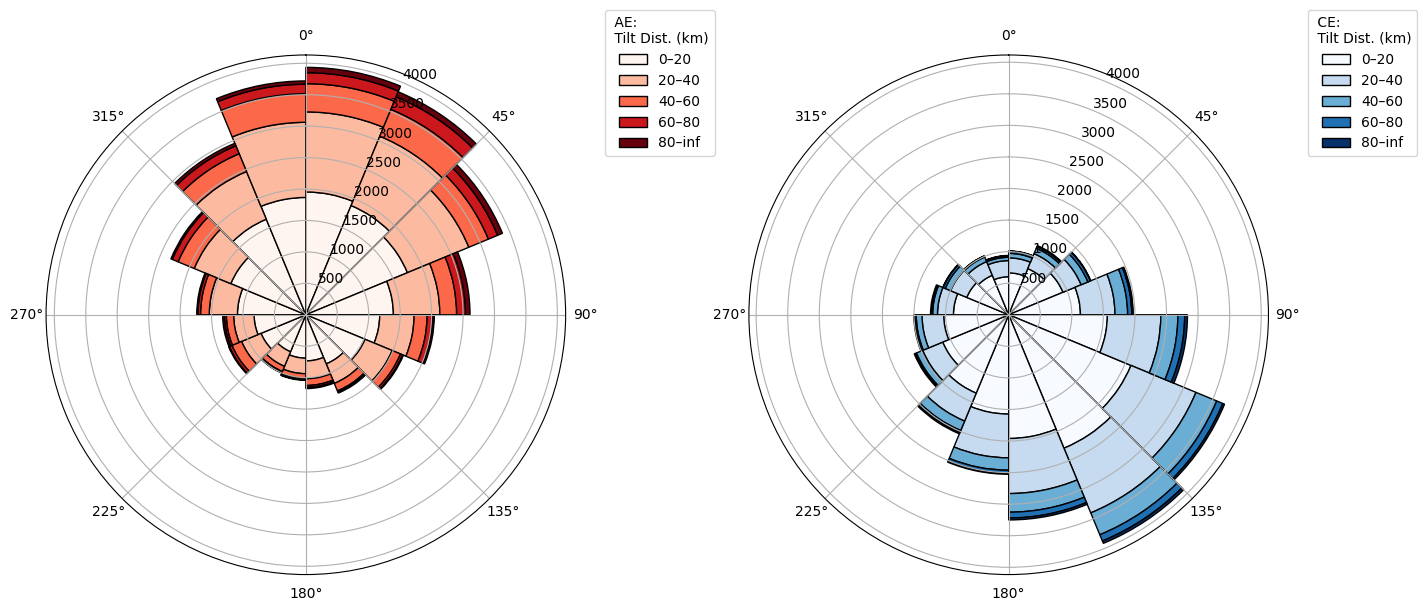

In [8]:
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()

# Define your bins once
dir_bins = np.linspace(0, 360, 17)      # 16 sectors
mag_bins = [0, 20, 40, 60, 80, np.inf]     # your strength categories
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / (len(dir_bins)-1)
colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1))
colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))

# Create figure + axes
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': 'polar'},
                        figsize=(14, 6),
                        constrained_layout=True)

for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    directions = df.TiltDir
    magnitudes = df.TiltDis

    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1

    # Count per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    # Plot stacked bars
    bottom = np.zeros(counts.shape[1])
    for i in range(counts.shape[0]):
        ax.bar(angles,
               counts[i],
               width,
               bottom=bottom,
               color=colors1[i] if a==0 else colors2[i],
               edgecolor='k',
               label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}')
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    # ax.set_title(f'{title}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title=f' {title}: \n Tilt Dist. (km)')

# One legend for both
plt.show()


In [31]:
df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()
df_AE_ = df_eddies[df_eddies.Cyc=='AE'].copy()
df_AE_ = df_AE_[~df_AE_.TiltDis.isna()]
df_CE_ = df_eddies[df_eddies.Cyc=='CE'].copy()
df_CE_ = df_CE_[~df_CE_.TiltDis.isna()]

print(f'AE-Days tilt equatorward {((df_AE_.TiltDir>=270) | (df_AE_.TiltDir<=90)).mean()*100:.2f}%')
print(f'AE-Days tilt equator-eastward {((df_AE_[(df_AE_.TiltDir>=270)|(df_AE_.TiltDir<=90)].TiltDir<=90)).mean()*100:.2f}%')
print(f'AE-Days tilt <= 40km {(df_AE_.TiltDis<=40).mean()*100:.2f}%')
print(f'AE-Days tilt >= 80km {(df_AE_.TiltDis>=80).mean()*100:.2f}%')


AE-Days tilt equatorward 69.13%
AE-Days tilt equator-eastward 56.20%
AE-Days tilt <= 40km 83.83%
AE-Days tilt >= 80km 1.69%


In [34]:
print(f'CE-Days tilt poleward {((df_CE_.TiltDir<=270) & (df_CE_.TiltDir>=90)).mean()*100:.2f}%')
print(f'CE-Days tilt poleward-eastward {((df_CE_[(df_CE_.TiltDir<=270) & (df_CE_.TiltDir>=90)].TiltDir<=180)).mean()*100:.2f}%')
print(f'CE-Days tilt <= 40km {(df_CE_.TiltDis<=40).mean()*100:.2f}%')
print(f'CE-Days tilt >= 80km {(df_CE_.TiltDis>=80).mean()*100:.2f}%')


AE-Days tilt poleward 68.38%
AE-Days tilt poleward-eastward 64.06%
AE-Days tilt <= 40km 88.09%
AE-Days tilt >= 80km 0.94%


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


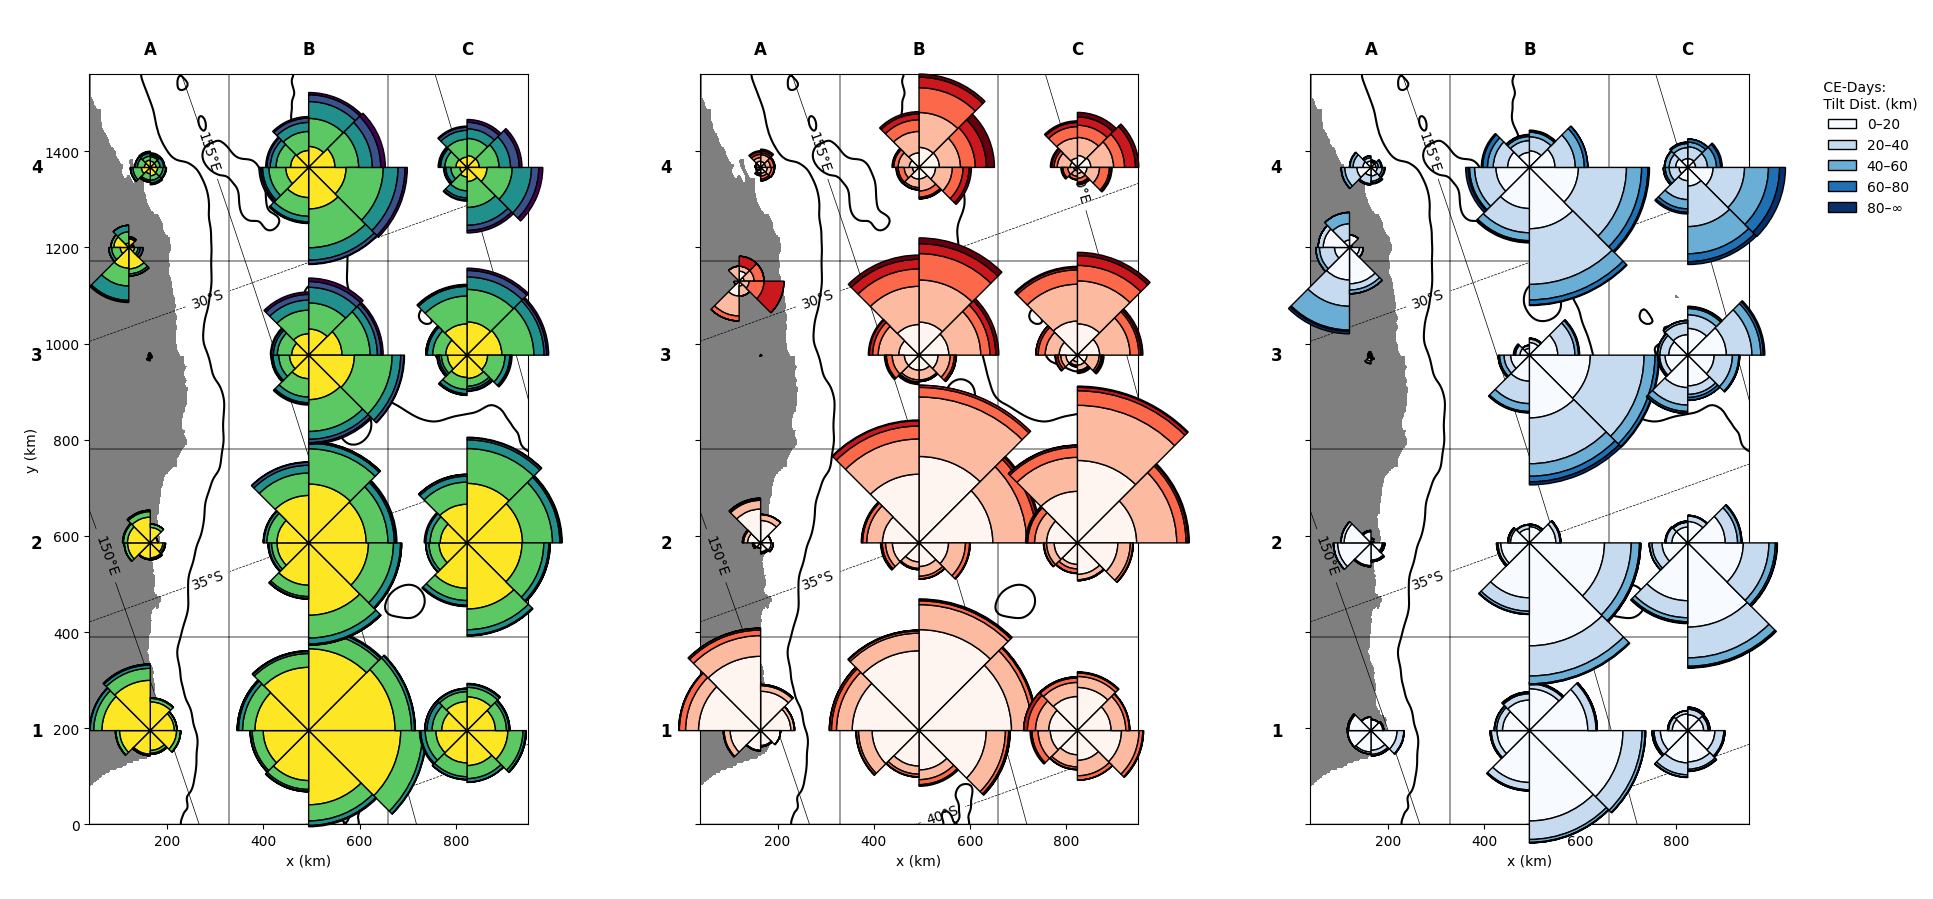

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

dir_bins = np.linspace(0, 360, 9)
mag_bins = [0, 20, 40, 60, 80, np.inf]
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2*np.pi / n_dirs
colors_cmps = [plt.cm.viridis_r(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))]

def windrose_counts(directions, magnitudes):
    if len(directions) == 0: return None
    d = np.digitize(np.mod(directions, 360), dir_bins) - 1
    m = np.digitize(magnitudes, mag_bins) - 1
    c = np.zeros((len(mag_bins)-1, n_dirs))
    for di, mi in zip(d, m):
        if 0 <= di < n_dirs and 0 <= mi < len(mag_bins)-1:
            c[mi, di] += 1
    return c

def add_windrose(ax, x0, y0, c, rmax, colors, frac=0.45, tick_flag=False, title=''):
    if c is None: return
    s = frac * min(cell_w, cell_h)
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData, projection='polar')
    bottom = np.zeros(n_dirs)
    for i in range(len(mag_bins)-1):
        hi = "∞" if np.isinf(mag_bins[i+1]) else f"{mag_bins[i+1]:g}"
        label = f"{mag_bins[i]:g}–{hi}"
        iax.bar(angles, c[i], width, bottom=bottom, edgecolor='k', color=colors[i], label=label)
        bottom += c[i]
    iax.set_theta_zero_location('N')
    iax.set_theta_direction(-1)
    iax.set_rlim(0, rmax)
    if tick_flag:
        iax.legend(title=title, loc='upper right', frameon=False, fontsize=10, title_fontsize=10, bbox_to_anchor=(1.35, .85))
    iax.set_xticks([]); iax.set_yticks([]); iax.set_frame_on(False)
    return iax

# precompute counts per cell + global rmax
def cell_counts(df):
    out, rmax = {}, 0.0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            d = np.asarray(sub.TiltDir.dropna().values, float)
            m = np.asarray(sub.TiltDis.dropna().values, float)
            n = min(len(d), len(m))
            c = windrose_counts(d[:n], m[:n])
            out[(i,j)] = c
            if c is not None:
                rmax = max(rmax, np.max(c.sum(axis=0)))
    return out, (1 if rmax == 0 else rmax)

fracs = [1.5, 2.0, 1.8]
fig, axs = plt.subplots(1, 3, figsize=(19, 9), sharey=True)
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k'); #ax.set_title(cyc)

    counts_map, rmax = cell_counts(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            if (i == 2) and (j==3):
                if p == 2:
                    tick_flag = True
            else:
                tick_flag = False

            add_windrose(ax, xc, yc, counts_map[(i,j)], rmax, colors_cmps[p], frac=fracs[p], tick_flag=tick_flag, title=' ' + titles[p] + ':\n Tilt Dist. (km)')
            if (i==0) and (j==2):
                if p == 1:
                    add_windrose(ax, 120, 1130, counts_map[(i,j)], rmax/40, colors_cmps[p], frac=fracs[p])
                else:
                    add_windrose(ax, 120, 1200, counts_map[(i,j)], rmax/10, colors_cmps[p], frac=fracs[p])
            
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    # column headers above each column
    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # row headers to the left of each row (counted from bottom)
    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        if p == 0:
            alpha = .06
        else:
            alpha = .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')
            
for ax in axs: ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
plt.tight_layout(); plt.show()
